In [1]:
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def display_images_center_crop(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        image = Image.open(image_path)
        width, height = image.size

        # 이미지 중앙의 정사각형 영역을 계산
        new_edge_length = min(width, height)
        left = (width - new_edge_length)/2
        top = (height - new_edge_length)/2
        right = (width + new_edge_length)/2
        bottom = (height + new_edge_length)/2

        # 중앙 영역 크롭
        image_cropped = image.crop((10, 20, width-10, height-15))

        # 크롭된 이미지 시각화
        plt.subplot(1, max_images, i+1)
        plt.imshow(image_cropped)
        plt.title(title)
        plt.axis('off')
    plt.show()

In [7]:
data_root = '/content/drive/MyDrive/컵퓨터비전 시즌4/5. 컴퓨터 비전/Data/3'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
categories = ['Train Glasses', 'Train NoGlasses', 'Val Glasses', 'Val NoGlasses', 'Test Glasses', 'Test NoGlasses']

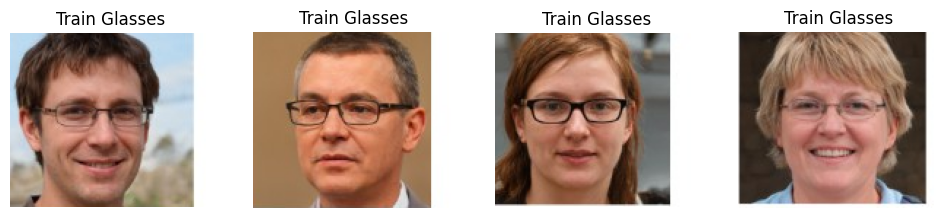

Train Glasses 총 이미지 수: 52


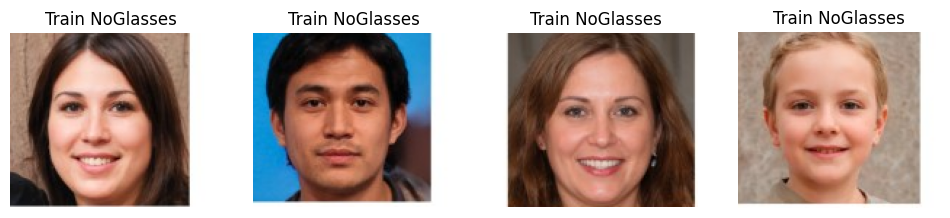

Train NoGlasses 총 이미지 수: 52


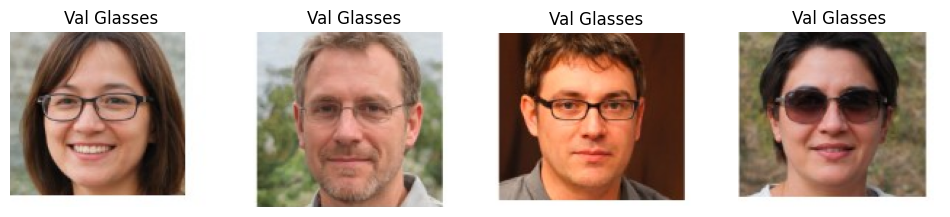

Val Glasses 총 이미지 수: 20


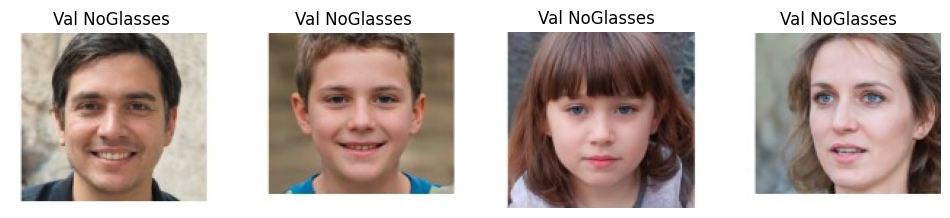

Val NoGlasses 총 이미지 수: 20


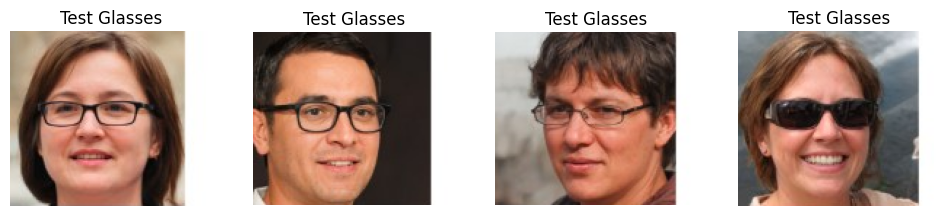

Test Glasses 총 이미지 수: 10


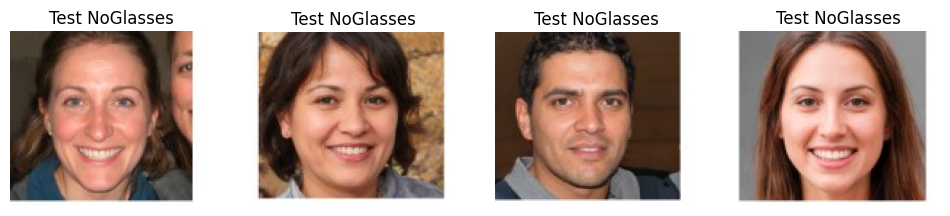

Test NoGlasses 총 이미지 수: 10


In [ ]:
for category in categories:
    image_paths = glob.glob(f'{data_root}/{category.lower().replace(" ", "/")}/*')
    # print(image_paths)
    display_images_center_crop(image_paths, category)
    print(f'{category} 총 이미지 수: {len(image_paths)}')

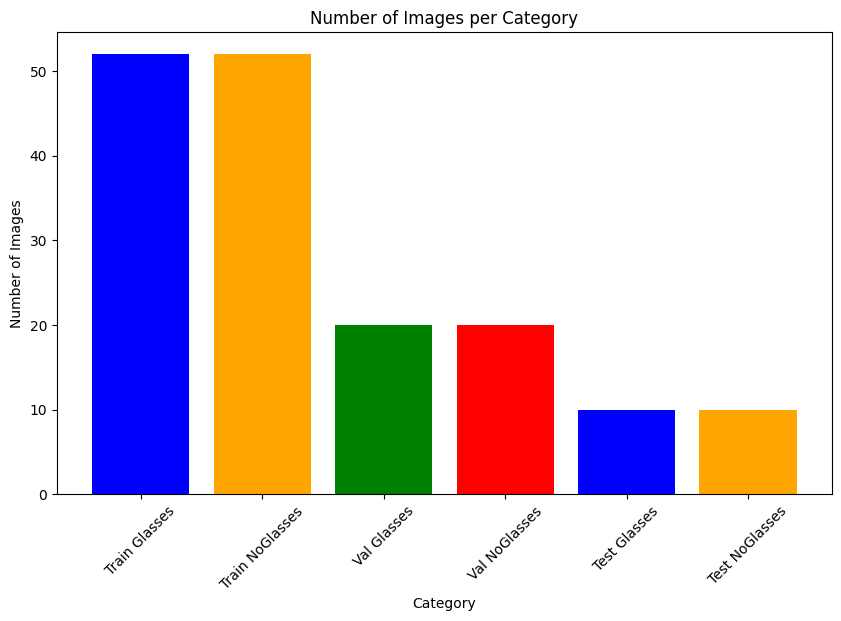

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'{data_root}/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 이미지를 무작위로 수평 뒤집기
    transforms.RandomRotation(30), # 이미지를 30도 무작위로 회전
    # 이미지의 밝기, 대비, 채도, 색조를 무작위로 변경
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2), # 20% 확률로 이미지를 그레이스케일로 변환
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = ImageFolder(f'{data_root}/train/', transform=transform)
val_dataset = ImageFolder(f'{data_root}/val/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(F.relu(self.conv5(x)))
        # FC Layer
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
model = AlexNet(num_classes=2)
model = model.to(device)

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = calculate_accuracy(val_loader, model)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss: .6f}, Val Loss: {val_loss: .6f}, Val Accuracy: {val_accuracy: .2f}%')

Epoch 1, Train Loss:  0.702226, Val Loss:  0.693287, Val Accuracy:  50.00%
Epoch 2, Train Loss:  0.695210, Val Loss:  0.692893, Val Accuracy:  50.00%
Epoch 3, Train Loss:  0.689644, Val Loss:  0.687456, Val Accuracy:  55.00%
Epoch 4, Train Loss:  0.606281, Val Loss:  1.052144, Val Accuracy:  50.00%
Epoch 5, Train Loss:  0.509560, Val Loss:  1.705037, Val Accuracy:  50.00%
Epoch 6, Train Loss:  0.432228, Val Loss:  0.964740, Val Accuracy:  52.50%
Epoch 7, Train Loss:  0.516723, Val Loss:  1.442688, Val Accuracy:  52.50%
Epoch 8, Train Loss:  0.470318, Val Loss:  1.738989, Val Accuracy:  55.00%
Epoch 9, Train Loss:  0.402412, Val Loss:  2.223023, Val Accuracy:  55.00%
Epoch 10, Train Loss:  0.285050, Val Loss:  1.353479, Val Accuracy:  60.00%
Epoch 11, Train Loss:  0.330581, Val Loss:  0.861534, Val Accuracy:  77.50%
Epoch 12, Train Loss:  0.198536, Val Loss:  1.276471, Val Accuracy:  70.00%
Epoch 13, Train Loss:  0.231934, Val Loss:  0.782245, Val Accuracy:  70.00%
Epoch 14, Train Loss: